# Time Series Aanalysis

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values. Time series are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series.

This notebook provides an example of how to train an ARIMA model in `pmdarima` libaray to generate forecasts of product sales in retail. We will train an ARIMA based model on the Superstore sales dataset.

`pmdarima` is a statistical library designed to fill the void in Python's time series analysis capabilities. It wraps statsmodels under the hood, but is designed with an interface that's familiar to users coming from a scikit-learn background.

* A collection of statistical tests of stationarity and seasonality
* Time series utilities, such as differencing and inverse differencing
* Numerous endogenous and exogenous transformers and featurizers, including Box-Cox and Fourier transformations
* Seasonal time series decompositions
* Cross-validation utilities
* Scikit-learn-esque pipelines to consolidate your estimators and promote productionization

#### Installation

```
$ pip install pmdarima
```

#### Reference: https://pypi.org/project/pmdarima/

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.utils import tsdisplay
from pmdarima.arima import ndiffs
from pmdarima.arima.utils import nsdiffs

sns.set(style="whitegrid")

## Loading Superstore Sales Data

In [5]:
data = pd.read_excel('../Data/Superstore.xls')
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data Preprocessing

* filtering categories
* removing columns we do not need
* checking missing values
* aggregating sales by date and so on.

There are several categories in the Superstore sales data, we start from time series analysis and forecasting for furniture sales.

In [6]:
print('Suersore categories: ', data.Category.unique())
furniture = data.loc[data.Category == 'Furniture']
furniture.head()

Suersore categories:  ['Furniture' 'Office Supplies' 'Technology']


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


### Data Validation (Time Range, Missing Values)

In [7]:
print('Time range: {} to {}'.format(furniture['Order Date'].min(), furniture['Order Date'].min()))

Time range: 2014-01-06 00:00:00 to 2014-01-06 00:00:00


In [8]:
print('Verify missing valuse:')
furniture.columns[furniture.isnull().sum()>0]

Verify missing valuse:


Index([], dtype='object')

### Data Aggregation

The `groupby` method can be used to aggregate our data by specific columns, but `resample` method also allow us to do aggregation by month, but we need set timestamp as index first.

In [11]:
furniture_sales = furniture.set_index('Order Date').Sales.resample('M').sum()
furniture_sales.head()

Order Date
2014-01-31     6242.525
2014-02-28     1839.658
2014-03-31    14573.956
2014-04-30     7944.837
2014-05-31     6912.787
Freq: M, Name: Sales, dtype: float64

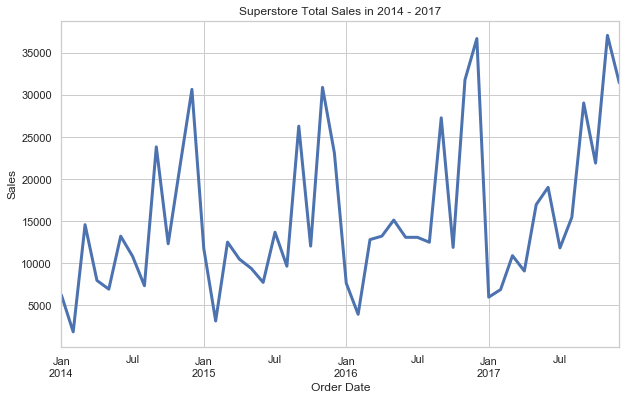

In [15]:
furniture_sales.plot(figsize=(10, 6), linewidth=3)
plt.ylabel('Sales')
plt.title('Superstore Total Sales in 2014 - 2017')
plt.show()

## ARIMA: Autoregressive Integrated Moving Average

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using an ARIMA(p,d,q) model within statsmodels library. In this notebook, we will be using an alternative library pmdarima, which allows us to automatically search for optimal ARIMA parameters, within a specified range. More specifically, we will be using auto_arima function within pmdarima to automatically discover the optimal parameters for an ARIMA model. This function wraps ARIMA and SARIMAX models of statsmodels library, that correspond to non-seasonal and seasonal model space, respectively.

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:

p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
q is the parameter associated with the moving average part of the model.,
If our data has a seasonal component, we use a seasonal ARIMA model or ARIMA(p,d,q)(P,D,Q)m. In that case, we have an additional set of parameters: P, D, and Q which describe the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model, and m refers to the number of periods in each season.

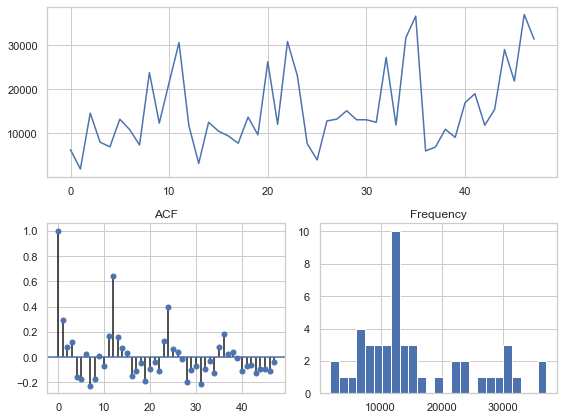

In [48]:
from pmdarima.utils import tsdisplay

tsdisplay(furniture_sales, lag_max=47)

### Periodic Term

The `m` parameter relates to the number of observations per seasonal cycle, and is one that **must be known apriori**.

* 7 - daily
* 12 - monthly
* 52 - weekly

### Estimating the differencing term

**An integrative term, `d`, is typically only used in the case of non-stationary data. Stationarity in a time series indicates that a series’ statistical attributes, such as mean, variance, etc., are constant over time. The value of `d` determines is the number of times the differences are computed.**

Auto-correlation plots as above are an easy way to determine whether your time series is sufficiently stationary for modeling. If the plot does not appear relatively stationary, your model will likely need a differencing term.

The `pmdarima.arima.stationarity` sub-module defines various tests of stationarity for testing a null hypothesis that an observable univariate time series is stationary around a deterministic trend (i.e. trend-stationary). More quantitatively determine to select the best number of differences such that the time series will be stationary.

Here, we’ll use the KPSS test and ADF test, selecting the maximum value between the two to be conservative. 

In [17]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(furniture_sales, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(furniture_sales, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print('Estimated differencing term: {}'.format(n_diffs))

Estimated differencing term: 0


### Estimating the seasonal differencing term

Sometimes trends are partially dependent on the time of year or month. Other times, they may be related to weather patterns. In either case, seasonality is a real consideration that must be made. The pmdarima package provides a test of seasonality for including seasonal terms in your ARIMA models.

Here we can use a Canova-Hansen test to estimate our seasonal differencing term.

In [37]:
from pmdarima.arima import ndiffs

# estimate number of seasonal differences using a Canova-Hansen test
CH_diffs = nsdiffs(furniture_sales, m=12, max_D=12, test='ch')

# or use the OCSB test (by default)
OCSB_diffs = nsdiffs(furniture_sales, m=12, max_D=12, test='ocsb')

sn_diffs = max(adf_diffs, kpss_diffs)

print('Estimated seasonal differencing term: {}'.format(sn_diffs))

Estimated seasonal differencing term: 0


In [49]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

test_size = 12
train, test = train_test_split(furniture_sales, test_size=test_size)
model = pm.auto_arima(train, seasonal=True, m=12, max_p=2, max_q=2, d=0, D=1, #D = 1 is best
                      trace=True, suppress_warnings=True, stepwise=True)

model.fit(train)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,12) [intercept=True]; AIC=481.109, BIC=490.534, Time=0.464 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=474.126, BIC=476.482, Time=0.007 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=474.869, BIC=479.581, Time=0.085 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=475.454, BIC=480.166, Time=0.080 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=475.721, BIC=476.899, Time=0.009 seconds
Fit ARIMA(0,0,0)x(1,1,0,12) [intercept=True]; AIC=473.691, BIC=477.225, Time=0.051 seconds
Fit ARIMA(0,0,0)x(2,1,0,12) [intercept=True]; AIC=473.743, BIC=478.455, Time=0.116 seconds
Fit ARIMA(0,0,0)x(1,1,1,12) [intercept=True]; AIC=474.015, BIC=478.727, Time=0.398 seconds
Near non-invertible roots for order (0, 0, 0)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,0,0)x(0,1,1,12) [intercept=True]; AIC=473.718, BIC=477.25

ARIMA(order=(0, 0, 0), seasonal_order=(1, 1, 0, 12), suppress_warnings=True)

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                -233.846
Date:                  Sun, 17 May 2020   AIC                            473.691
Time:                          17:15:07   BIC                            477.225
Sample:                               0   HQIC                           474.629
                                   - 36                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1737.8577   1110.599      1.565      0.118    -438.877    3914.592
ar.S.L12      -0.1274      0.073     -1.741      0.082      -0.271       0.016
sigma2      1.883e+07      0.154   1.22e+08      0.000    1.88e+07    1.88e+07
===================================================================================
Ljung-Box (Q):                       39.28   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.02   Prob(JB):                         0.30
Heteroskedasticity (H):               2.23   Skew:                             0.70
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.54e+23. Standard errors may be unstable.
"""

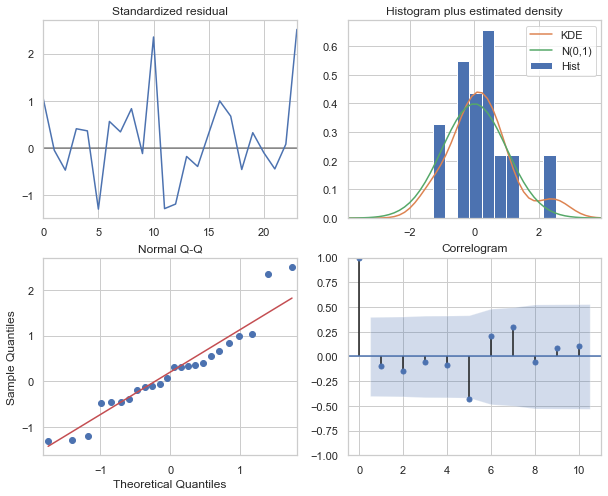

In [45]:
model.plot_diagnostics(figsize=(10, 8))
plt.show()

The Root Mean Squared Error is 4148.49
SMAPE is 23.9


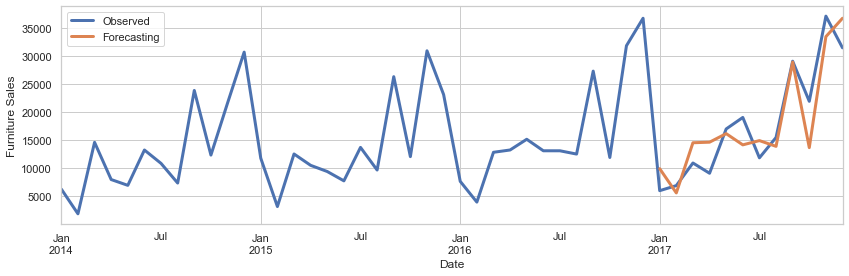

In [46]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

pred = model.predict(n_periods=test_size)
pred = pd.Series(pred, index=furniture_sales.index[-test_size:])

RMSE = round(np.sqrt(mean_squared_error(test, pred)),2)
SMAPE = round(smape(test, pred),2)
print('The Root Mean Squared Error is {}'.format(RMSE))
print('SMAPE is {}'.format(SMAPE))

ax = furniture_sales.plot(label='Observed', figsize=(14, 4), linewidth=3)
pred.plot(ax=ax, label='Forecasting', linewidth=3)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Updating model & Forecasting

The easiest way to keep your model up-to-date without completely refitting it is simply to update your model with new observations so that future forecasts take the newest observations into consideration. 

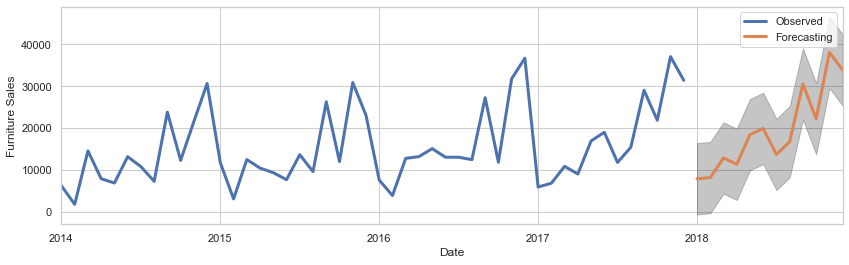

In [47]:
start = furniture_sales.index[-1] + pd.Timedelta(1, unit='M')
end = start + pd.Timedelta(test_size, unit='M')
time_range = pd.date_range(start, end, freq='M')

model.update(test)

pred, confi = model.predict(n_periods=test_size, return_conf_int=True)
pred = pd.Series(pred, name='Forecasting', index=time_range).reset_index()
confi = pd.DataFrame(confi, columns=['pred_lower', 'pred_upper'])

pred['Order Date'] = pred['index'].dt.date.astype('datetime64[ns]')
pred.set_index('Order Date', inplace=True)
pred.drop('index', axis=1, inplace=True)

ax = furniture_sales.plot(label='Observed', figsize=(14, 4), linewidth=3)
pred.plot(ax=ax, label='Forecasting', linewidth=3)
ax.fill_between(pred.index,
                confi.iloc[:, 0],
                confi.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Transforming our data

Since we expect our model to perform better over more normal data, let’s experiment with `Log` transformations and the `Box-Cox` transformation, each of which is provided as an endogenous transformer in the `pmdarima` package.

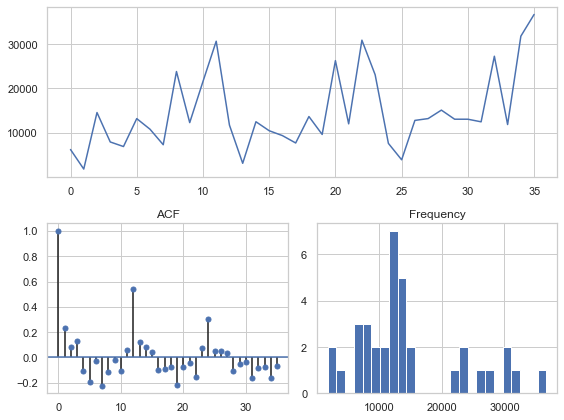

In [52]:
from pmdarima.preprocessing import LogEndogTransformer

train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(train)
tsdisplay(train, lag_max=35)

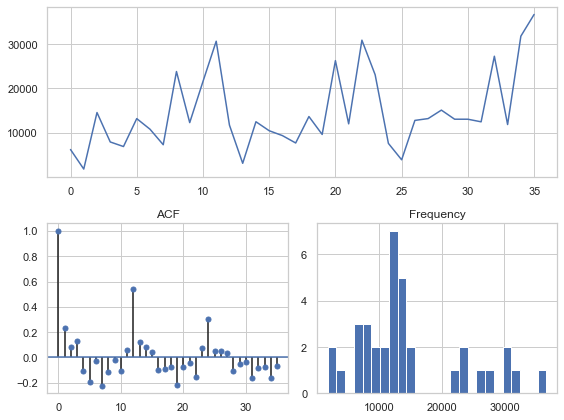

In [53]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

train_boxcox, _ = BoxCoxEndogTransformer(lmbda=1e-6).fit_transform(train)
tsdisplay(train, lag_max=35)

In [54]:
from scipy.stats import normaltest

# p-value
normaltest(train_boxcox)[1]

0.09169307757247984

### Pipeline Work

`pmdarima` implements a scikit-learn-esque pipeline used to chain transformations and estimators together. Using this, we can centralize the entire transformer/model fit into one metaestimator.

In [70]:
from pmdarima.pipeline import Pipeline

model_pipe = Pipeline([('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
                 ('arima', pm.AutoARIMA(seasonal=True, m=12, max_p=2, max_q=2, d=0, D=1,
                                        trace=True, suppress_warnings=True, stepwise=True))])

model_pipe.fit(furniture_sales)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,1,1,12) [intercept=True]; AIC=208.292, BIC=220.960, Time=0.974 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=208.515, BIC=211.682, Time=0.009 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=209.486, BIC=215.820, Time=0.113 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=207.943, BIC=214.277, Time=0.110 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=212.263, BIC=213.846, Time=0.012 seconds
Fit ARIMA(0,0,1)x(0,1,0,12) [intercept=True]; AIC=209.629, BIC=214.380, Time=0.032 seconds
Fit ARIMA(0,0,1)x(1,1,1,12) [intercept=True]; AIC=209.848, BIC=217.765, Time=0.285 seconds
Fit ARIMA(0,0,1)x(0,1,2,12) [intercept=True]; AIC=209.841, BIC=217.759, Time=0.369 seconds
Fit ARIMA(0,0,1)x(1,1,0,12) [intercept=True]; AIC=208.680, BIC=215.014, Time=0.100 seconds
Fit ARIMA(0,0,1)x(1,1,2,12) [intercept=True]; AIC=211.813, BIC=221.315, Time=1.451 seconds
Near non-invertible roots for order (0, 0, 1)(

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima',
                 AutoARIMA(D=1, d=0, m=12, max_p=2, max_q=2,
                           suppress_warnings=True, trace=True))])

In [71]:
model_pipe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -98.203
Date:                            Sun, 17 May 2020   AIC                            206.405
Time:                                    20:15:22   BIC                            214.323
Sample:                                         0   HQIC                           209.169
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6855      0.540      1.269      0.204      -0.373       1.744
ar.L1          0.5790      0.311      1.860      0.063      -0.031       1.189
ma.L1         -0.9996     64.731     -0.015      0.988    -127.870     125.871
ma.S.L12      -0.3566      0.317     -1.127      0.260      -0.977       0.264
sigma2        12.1032    782.849      0.015      0.988   -1522.253    1546.459
===================================================================================
Ljung-Box (Q):                       41.87   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.20   Prob(JB):                         0.47
Heteroskedasticity (H):               1.10   Skew:                            -0.29
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

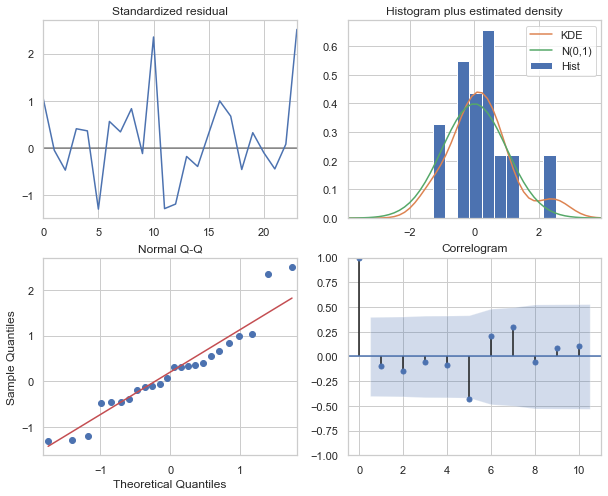

In [72]:
model.plot_diagnostics(figsize=(10, 8))
plt.show()

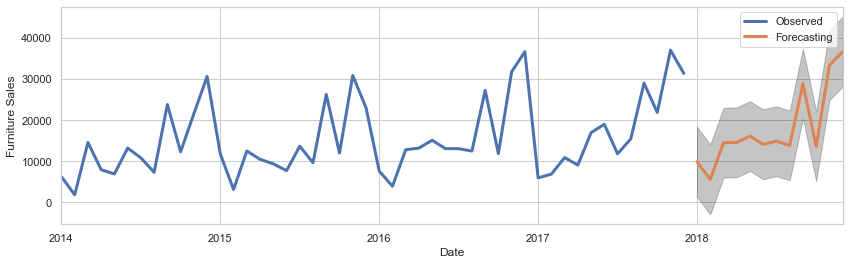

In [73]:
pred, confi = model.predict(n_periods=test_size, return_conf_int=True)
pred = pd.Series(pred, name='Forecasting', index=time_range).reset_index()
confi = pd.DataFrame(confi, columns=['pred_lower', 'pred_upper'])

pred['Order Date'] = pred['index'].dt.date.astype('datetime64[ns]')
pred.set_index('Order Date', inplace=True)
pred.drop('index', axis=1, inplace=True)

ax = furniture_sales.plot(label='Observed', figsize=(14, 4), linewidth=3)
pred.plot(ax=ax, label='Forecasting', linewidth=3)
ax.fill_between(pred.index,
                confi.iloc[:, 0],
                confi.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Serializing ARIMA models

In [75]:
# For serialization:
import pickle

# Serialize with Pickle
with open('arima.pkl', 'wb') as pkl:
    pickle.dump(model_pipe, pkl)
    
# Now read it back and make a prediction
with open('arima.pkl', 'rb') as pkl:
    pickle_preds = pickle.load(pkl).predict(n_periods=5)